In [15]:
import numpy as np

In [16]:
%ls

 98bk02.h5         dTb02              lvac02.png                   sc.py
 binary_data_02/   EmuBk0.2.h5        nbins02                      script.py
 bk_norm02         hyperparam.ipynb   N_bins_test                  x_HI02
 Bk_test           index              params02
 bk_un02           index.png          params_test
 cov_inv_test      __init__.py       'paramter estimation.ipynb'


In [17]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)


BANN = '/home/ht/EmuPBk/data/data_Bispectrum/bkkkk0.3.h5'

def Bk_th(params):
    
    
    '''21-cm Bispectrum Emulator based on ANN, given the parameters (Nion, Rmfp, NoH) it
    will give Bispectrum array (50*11) cosalpha*k_2/k_1'''
    
    
    Denorm = 10000
    model = tf.keras.models.load_model(BANN)
    Pk_pdct = model.predict([[params]])
    Pk_pdct = Pk_pdct*Denorm
    Pk_pdct = np.around(Pk_pdct,1)
    
    return Pk_pdct

In [13]:
Bk_th()

<function __main__.Bk_th(params)>

In [14]:
path = '/home/ht/EmuPBk/data/data_Bispectrum/k0.3/'

In [5]:
Bk = np.loadtxt(path+'bk_norm03')
params = np.loadtxt('params02')

In [6]:
N_bins = np.loadtxt(path+'nbins03')
N_bins.shape

(1058, 550)

In [7]:
ind= np.loadtxt('index')
index = np.zeros(len(ind),dtype=int)
for i in range(len(ind)):
    index[i] = ind[i]

array([ 146,  833,  516,  204,  929,  223,  154,   42,   87,   10,  535,
        343,  525,  239,   37,  532,  966, 1043])

In [8]:
Bk =  np.around(Bk,1)

In [9]:

nbins_test = N_bins[index]

Bk_03_test = Bk[index]

Bk_03_train = np.delete(Bk,index,axis=0)

Bk_03_train = Bk_03_train

params_test = params[index]

params_train = np.delete(params,index,axis=0)

params_train = params_train

In [10]:
params_test[12]

array([130.,  45., 200.])

In [11]:
def cov(Bk,Nbins):
    a = np.eye(550,550)
    b = Bk/np.sqrt(Nbins)
    b = np.reshape(b,(550,1))
    b = b*a
    cov_inv = np.linalg.inv(b)
    return cov_inv

In [12]:
def logL(params):
    
    nion , rmfp , noh = params
    
    if nion < 0. or nion > 220. or rmfp < 0. or rmfp > 130. or noh < 50. or noh > 1500.:
        logl = -np.inf
        
    else:
        ind = 12
        Bk = np.reshape(Bk_03_test[ind],(1,550))
        diff = np.subtract(Bk_th(params),Bk)
        cov_inv = cov(Bk_03_test[ind],nbins_test[ind])
        

        logl = -0.5*np.dot(np.dot(diff,cov_inv),diff.T)
        logl = logl[0]
        #logl = logl/1000.
        
    return logl
        

In [13]:

p

'/home/ht/EmuPBk/data/data_Bispectrum/bkkkk0.3.h5'

In [14]:
logL(params_test[12])

array([-4286.36645154])

In [31]:
import emcee
import time
from multiprocessing import Pool

nwalkers = 6
ndim = 3
a = np.random.randint(20,220,nwalkers)
b = np.random.randint(5,130,nwalkers)
c = np.random.randint(50,1500,nwalkers)
p = np.zeros(shape=(6,3))
p[:,0] = a
p[:,1] = b
p[:,2] = c

In [32]:
nsteps = 2000

sampler = emcee.EnsembleSampler(nwalkers, ndim, logL,threads=16,)
start = time.time()
sampler.run_mcmc(p, nsteps, progress=True)
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 2000/2000 [1:14:12<00:00,  2.23s/it]   

Multiprocessing took 4453.9 seconds


In [33]:
s_flat = sampler.flatchain
logl  = sampler.flatlnprobability

In [34]:
logl.shape

(12000,)

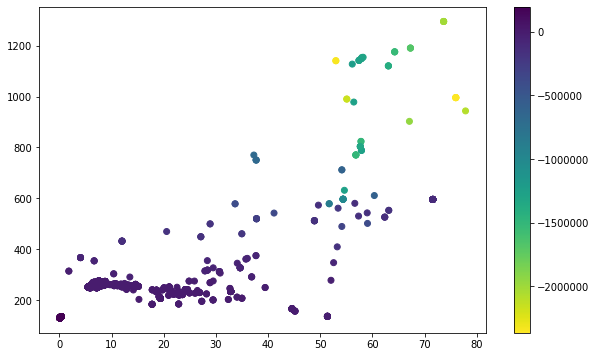

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(s_flat[:,1],s_flat[:,2],c = logl,cmap="viridis_r")
plt.colorbar()

array([130.,  45., 200.])

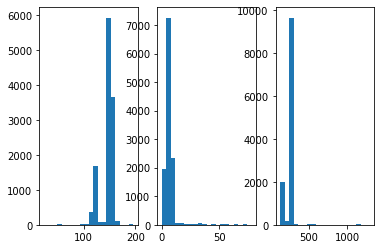

In [37]:
plt.subplot(1,3,1)
plt.hist(s_flat[:,0],bins=20)
plt.subplot(1,3,2)
plt.hist(s_flat[:,1],bins=20)
plt.subplot(1,3,3)
plt.hist(s_flat[:,2],bins=20)
params_test[12]

In [ ]:
k1 = np.array([0.1903934])
#k1 = np.array([0.3220935, 1.559453 ])
k2byk1 = np.arange(0.50,1.05,0.05) 		#======Ratio k2byk1========#
cosalpha = np.arange(0.50,1.00,0.01)	#======cosine of the angle between the k2 and k1 arms =======#
k2byk1 = k2byk1.reshape(11,1)
k2byk1.shape, cosalpha.shape

In [ ]:
Bk_02_pdct = Bk_th(params_test)

In [ ]:
Bk_test = np.zeros(shape=(len(Bk_02_test),11,50))
Bk_pdct = np.zeros(shape=(len(Bk_02_test),11,50))
for i in range(len(Bk_02_test)):
    Bk_pdct[i] = Bk_02_pdct[i].reshape(11,50)
    Bk_test[i] = Bk_02_test[i].reshape(11,50)

Bk_test = Bk_test


In [ ]:
cond = k2byk1*cosalpha


In [ ]:
cond = k2byk1*cosalpha
for i in range(len(Bk_test)):
    for j in range(len(k2byk1)):
        for k in range(len(cosalpha)):
            if cond[j][k] < 0.5:
                Bk_pdct[i][j][k] = np.nan
                Bk_test[i][j][k] = np.nan

Bk_pdct = np.ma.masked_invalid(Bk_pdct)
Bk_test = np.ma.masked_invalid(Bk_test)

In [ ]:
def plot(test_set):
    index = test_set
    plt.figure(figsize= (16,6))
    plt.tick_params(labelsize=10)

    #fig.colorbar(pcm, ax=ax[0], extend='both')
    plt.suptitle(r'At $k_1$ = {0:f}, $\zeta$ = {1:.2f}, $Rmfp$= {2:.2f}, $M_h$= {3:.2f}$\times 10^8 M_\odot$'
                 .format(k1[0],params_test[index][0] , params_test[index][1] ,1.087*params_test[index][2]),size=15)
    
   
    plt.subplot(1,2,1)
    plt.title('Bispectrum')
    plt.imshow(Bk_test[index],origin='lower',extent=[0.50,0.99,0.50,1.00], cmap="Spectral",norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-10000.0, vmax=10000.0))
    cbar = plt.colorbar(label=r"$\frac{k_1^3.k_2^3.B(k_1,k_2,k_3).\delta T_b^3}{(2\pi^2)^2}$",)
    cbar.ax.yaxis.label.set_size(20,)
    plt.xlabel(r'$cos(\alpha)$')
    plt.ylabel(r'$k_2/k_1$')   
    
    plt.subplot(1,2,2)
    plt.title('ANN prediction')
    plt.imshow(Bk_pdct[index],origin='lower',extent=[0.50,0.99,0.50,1.00], cmap="Spectral",norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-10000.0, vmax=10000.0))
    cbar = plt.colorbar(label=r"$\frac{k_1^3.k_2^3.B(k_1,k_2,k_3).\delta T_b^3}{(2\pi^2)^2}$",)
    cbar.ax.yaxis.label.set_size(20,)
    plt.ylabel(r'$k_2/k_1$') 
    plt.xlabel(r'$cos(\alpha)$')
    
  

            

In [ ]:
from ipywidgets import interact
from matplotlib import colors

interact(plot,test_set=(0,17,1))